In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/financial_anomaly_data.csv") # Dataset includes: Timestamp, Amount, AccountID, Merchant, TransactionType, Location

In [4]:
# Connect to SQLite (in-memory for demo)
conn = sqlite3.connect(":memory:")
df.to_sql("Transactions", conn, index=False, if_exists="replace")

217441

In [5]:
# 2. SQL Queries (KPIs & Anomalies)

#Total Transaction Volume
query = "SELECT SUM(Amount) AS Total_Volume FROM Transactions;"
pd.read_sql(query, conn)

,Total_Volume
0,1.086753e+10


In [6]:
#Average Spend per Transaction
query = "SELECT AVG(Amount) AS Avg_Spend FROM Transactions;"
pd.read_sql(query, conn)

,Avg_Spend
0,50090.025108


In [7]:
#Total Transaction Count
query = "SELECT COUNT(*) AS Txn_Count FROM Transactions;"
pd.read_sql(query, conn)

,Txn_Count
0,217441


In [8]:
#Top 5 accounts by total spend
query = """
SELECT AccountID, SUM(Amount) AS Total_Spent
FROM Transactions
GROUP BY AccountID
ORDER BY Total_Spent DESC
LIMIT 5;
"""
pd.read_sql(query, conn)

,AccountID,Total_Spent
0,ACC15,7.405172e+08
1,ACC5,7.343486e+08
2,ACC7,7.302093e+08
3,ACC13,7.288201e+08
4,ACC2,7.283480e+08


In [9]:
#Revenue concentration among top 10 merchants
query = """
SELECT Merchant, SUM(Amount) AS Merchant_Revenue
FROM Transactions
GROUP BY Merchant
ORDER BY Merchant_Revenue DESC
LIMIT 10;
"""
pd.read_sql(query, conn)

,Merchant,Merchant_Revenue
0,MerchantF,1.098405e+09
1,MerchantI,1.097515e+09
2,MerchantB,1.091463e+09
3,MerchantJ,1.090347e+09
4,MerchantG,1.089832e+09
5,MerchantD,1.086746e+09
6,MerchantA,1.086195e+09
7,MerchantH,1.081502e+09
8,MerchantE,1.079224e+09
9,MerchantC,1.066303e+09


In [10]:
#Peak Hour Activity
query = """
SELECT
    CAST(strftime('%H',
        substr(Timestamp, 7, 4) || '-' ||   -- Year
        substr(Timestamp, 1, 2) || '-' ||   -- Month
        substr(Timestamp, 4, 2) || ' ' ||   -- Day
        substr(Timestamp, 12)                -- Time
    ) AS INTEGER) AS Hour,
    COUNT(*) AS Txn_Count
FROM Transactions
WHERE Timestamp IS NOT NULL
GROUP BY Hour
ORDER BY Txn_Count DESC;
"""
pd.read_sql(query, conn)

,Hour,Txn_Count
0,NaN,131040
1,23.0,3600
2,22.0,3600
3,21.0,3600
4,20.0,3600
5,19.0,3600
6,18.0,3600
7,17.0,3600
8,16.0,3600
9,15.0,3600


In [11]:
#High value Anomalies
query = """
WITH stats AS (
    SELECT
        AVG(Amount) AS mean,
        AVG(Amount * Amount) - AVG(Amount) * AVG(Amount) AS variance
    FROM Transactions
)
SELECT t.*
FROM Transactions t
JOIN stats s ON 1=1
WHERE t.Amount > s.mean + 2 * SQRT(s.variance);
"""
pd.read_sql(query, conn)

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,03-01-2023 06:15,TXN1049,ACC14,978942.26,MerchantJ,Transfer,New York
1,03-01-2023 17:28,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo
2,03-01-2023 17:33,TXN1690,ACC8,489492.30,MerchantF,Purchase,Tokyo
3,04-01-2023 05:08,TXN625,ACC1,187344.37,MerchantD,Purchase,San Francisco
4,04-01-2023 05:54,TXN667,ACC3,272990.11,MerchantE,Transfer,Los Angeles
5,01-02-2023 15:39,TXN1359,ACC11,151020.55,MerchantB,Transfer,Tokyo
6,01-02-2023 15:40,TXN190,ACC5,873004.79,MerchantI,Withdrawal,Los Angeles
7,01-02-2023 15:48,TXN1660,ACC8,109150.02,MerchantF,Withdrawal,London
8,28-05-2023 08:34,TXN1920,ACC5,124103.08,MerchantB,Purchase,New York
9,28-05-2023 09:13,TXN141,ACC4,223542.64,MerchantG,Withdrawal,San Francisco


In [12]:
#Data Cleaning
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True, errors='coerce') #It converts the TimeStamp column in the dataset from strings to pandas datetime objects.
                                                                                  #So after this we can use the normal date/time operations for extracting the hour day and month.

In [80]:
print(df[df['Timestamp'].isna()]) #Checks for any invalid or null timestamps

       Timestamp TransactionID AccountID  Amount Merchant TransactionType  \
216960       NaT           NaN       NaN     NaN      NaN             NaN   
216961       NaT           NaN       NaN     NaN      NaN             NaN   
216962       NaT           NaN       NaN     NaN      NaN             NaN   
216963       NaT           NaN       NaN     NaN      NaN             NaN   
216964       NaT           NaN       NaN     NaN      NaN             NaN   
...          ...           ...       ...     ...      ...             ...   
217436       NaT           NaN       NaN     NaN      NaN             NaN   
217437       NaT           NaN       NaN     NaN      NaN             NaN   
217438       NaT           NaN       NaN     NaN      NaN             NaN   
217439       NaT           NaN       NaN     NaN      NaN             NaN   
217440       NaT           NaN       NaN     NaN      NaN             NaN   

       Location  Hour  DayOfWeek  IsWeekend  Merchant_enc  TxnType_enc  \
2

In [81]:
df['Hour'] = df['Timestamp'].dt.hour                                   #.dt.hour extracts the hour (0–23) from each datetime in the Timestamp column and stores it in Hour dataframe
peak_hours = df.groupby('Hour').size().sort_values(ascending=False)
print(peak_hours)  #The result gives the number of transcactions that occured in each hour of the day.

Hour
15.0    9060
14.0    9060
13.0    9060
12.0    9060
11.0    9060
10.0    9060
9.0     9060
8.0     9060
16.0    9060
17.0    9060
18.0    9060
19.0    9060
20.0    9060
21.0    9060
22.0    9060
23.0    9060
7.0     9000
6.0     9000
5.0     9000
4.0     9000
3.0     9000
2.0     9000
1.0     9000
0.0     9000
dtype: int64


In [82]:
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
print(df['DayOfWeek'])  #dt.dayofweek assigns 0-> Monday, 1-> Tuesday and so on

0         6.0
1         6.0
2         6.0
3         6.0
4         6.0
         ... 
217436    NaN
217437    NaN
217438    NaN
217439    NaN
217440    NaN
Name: DayOfWeek, Length: 217441, dtype: float64


In [83]:
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
df['IsWeekend']

,IsWeekend
0,1
1,1
2,1
3,1
4,1
...,...
217436,0
217437,0
217438,0
217439,0


In [84]:
# Encode categorical variables

le = LabelEncoder()

df['merchant_enc'] = le.fit_transform(df['Merchant'])
df['txntype_enc'] = le.fit_transform(df['TransactionType'])
df['location_enc'] = le.fit_transform(df['Location'])

In [85]:
# KPIs
# Detect high-value anomalies using statistical rule
total_volume = df['Amount'].sum()
avg_spend = df['Amount'].mean()
anomaly_threshold = df['Amount'].mean() + 2*df['Amount'].std()
anomalies = df[df['Amount'] > anomaly_threshold]

In [86]:
print(f"Total Volume: ${total_volume:,.2f}")
print(f"Average Spend: ${avg_spend:,.2f}")
print(f"Anomaly Transactions: {len(anomalies)} / {len(df)}")

Total Volume: $10,867,531,847.33
Average Spend: $50,090.03
Anomaly Transactions: 14 / 217441


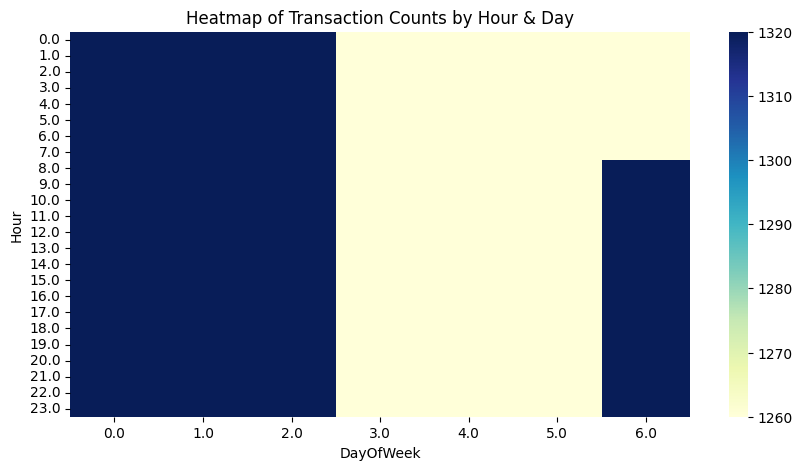

In [87]:
# Visualization
# Heatmap: Transaction counts by Hour and DayOfWeek
plt.figure(figsize=(10,5))
sns.heatmap(df.pivot_table(index='Hour', columns='DayOfWeek', values='Amount', aggfunc='count').fillna(0), cmap="YlGnBu")
plt.title("Heatmap of Transaction Counts by Hour & Day")
plt.show()

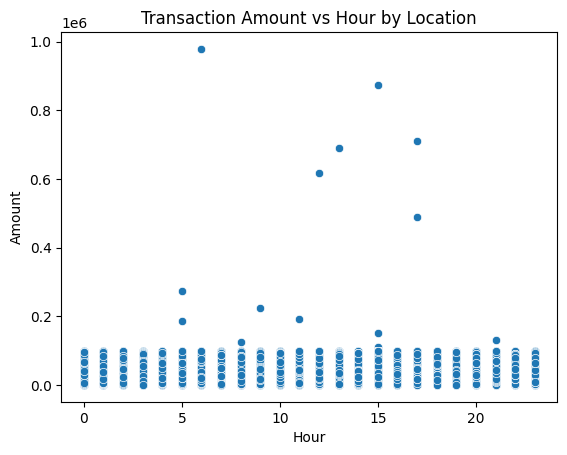

In [65]:
# Scatterplot: Transaction Amount vs Hour
sns.scatterplot(x="Hour", y="Amount", data=df)
plt.title("Transaction Amount vs Hour by Location")
plt.show()

/tmp/ipython-input-1784612273.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Merchant", y="Amount", data=df, estimator=sum, ci=None)


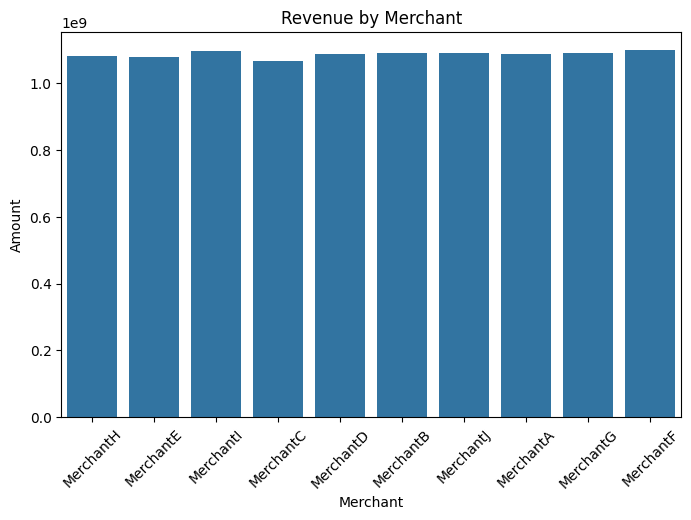

In [88]:
# Barplot: Revenue by Merchant
plt.figure(figsize=(8,5))
sns.barplot(x="Merchant", y="Amount", data=df, estimator=sum, ci=None)
plt.title("Revenue by Merchant")
plt.xticks(rotation=45)
plt.show()

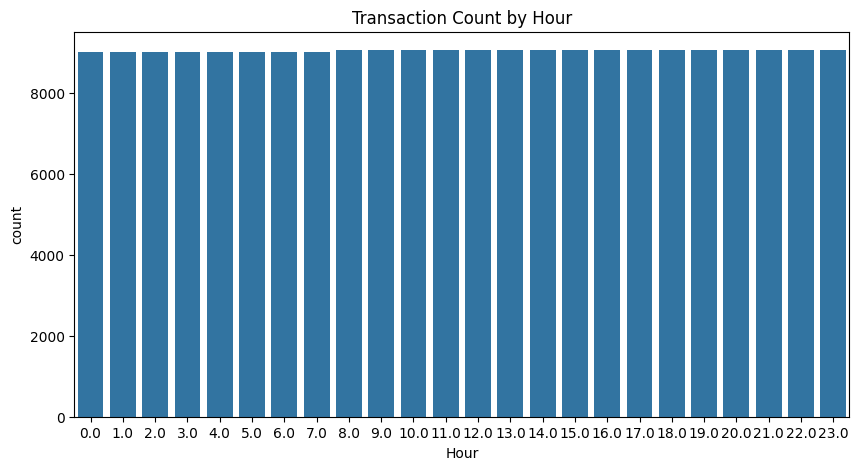

In [89]:
#Transaction Count by Hour
plt.figure(figsize=(10,5))
sns.countplot(x="Hour", data=df)
plt.title("Transaction Count by Hour")
plt.show()

In [113]:
df_clean = df.loc[features_clean.index]
X_scaled = scaler.fit_transform(features_clean)

In [114]:
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)
distances = kmeans.transform(X_scaled).min(axis=1)
threshold = np.percentile(distances, 95)

In [111]:
# Assign anomalies only to the rows used for clustering
df.loc[features_clean.index, 'Anomaly'] = (distances > threshold).astype(int)

In [112]:
# KPI from clustering
anomaly_rate = df['Anomaly'].mean() * 100
print(f"\nAnomaly Rate (KMeans Distance Rule): {anomaly_rate:.2f}%")
print("Top 5 High-Risk Accounts:\n", df[df['Anomaly']==1]['AccountID'].value_counts().head())



Anomaly Rate (KMeans Distance Rule): 5.00%
Top 5 High-Risk Accounts:
 AccountID
ACC7     749
ACC10    748
ACC11    747
ACC5     746
ACC14    745
Name: count, dtype: int64


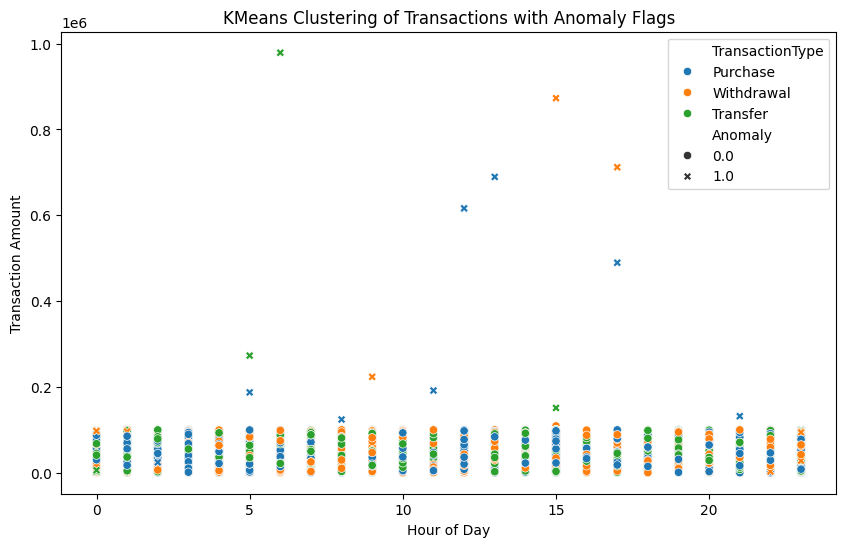

In [67]:
# Visualization of clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='Hour', y='Amount', hue='TransactionType', data=df, palette="tab10", style='Anomaly')
plt.title("KMeans Clustering of Transactions with Anomaly Flags")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Amount")
plt.show()

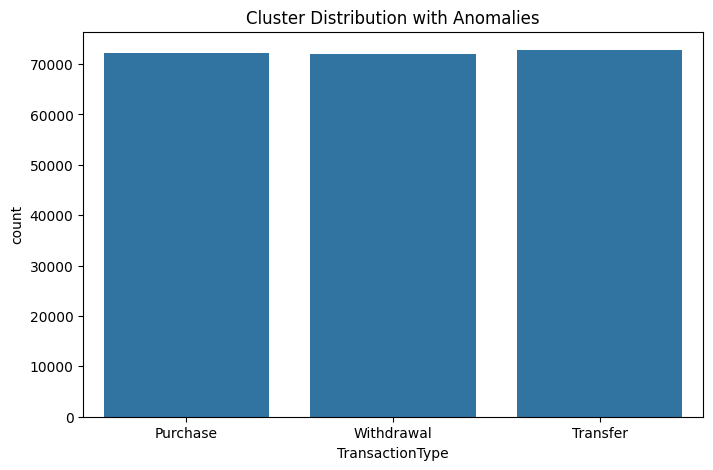

In [64]:
plt.figure(figsize=(8,5))
sns.countplot(x='TransactionType', data=df)
plt.title("Cluster Distribution with Anomalies")
plt.show()

In [70]:
X = df[['Amount','Hour','DayOfWeek','Merchant_enc','location_enc']]
y = df['TxnType_enc']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [77]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87     14447
           1       0.87      0.86      0.86     14559
           2       0.87      0.86      0.86     14387
           3       1.00      1.00      1.00        96

    accuracy                           0.87     43489
   macro avg       0.90      0.90      0.90     43489
weighted avg       0.87      0.87      0.87     43489

